## Football Match Probability 

### Framing the Problem

Over the course of the past decade, the data revolution and machine learning practices have made their way into the world of sports. Considering these technologies, there is a divide between their users and use cases within this subsector of sports. For this problem, we will be trying to understand the data in the context that a sportsbook would when setting lines for a match, which is largely done by machine learning in the real world. Actually, the dataset includes the sportsbook's odds converted into probabilities as a benchmark for our model's performance. 

When considering soccer matches, as is our data, the optimal solution & our target is predicting the number of goals each team would score in any given game and this would then yield the match result. For example, if Team A is predicted to score 3 goals and Team B is predicted to score 1 goal, then obviously Team A is the winner. In a machine learning context, this essentially means that we are dealing with a highly multivariate and multioutput regression problem. While it is possible to say this problem could be solved through classification, using regression achieves the same result & actually yields more notable information (ie. the goals scored) than a binary output. Having this extra information would allow us to take bets that are advantageous to us on a risk-adjusted basis. For example, should we expect Team A to score 3 goals & Team B to score 2 goals as mentioned earlier, we likely would not want to be on the outcome of the winner for this game due to the tight spread. Instead, accounting for risk which is another machine learning problem within itself, we would opt for possibly placing a bet on total goals scored in the game since it is expected to be high scoring.

Within our dataset, we are dealing with over 150,000 instances of match outcomes, with each team's last ten matches being represented within the data. Only accounting for the most recent matches is important because momentum plays a large role in performance in sports, not to mention injuries and other short-term related mishaps would impact results should you be predicting on a larger set of instances. Additionally, it is important to consider that predictions should be made on factors outside of specific team performance, as the same prediction logic must be generalized to all instances within the dataset. Looking further into our data, the role of the calender and the dates on which games were played is extremely important due to the momentum factor involved in sports as mentioned previously. Due to this, we will have to explore new methods of dealing with time series/sequential data, which could also be applied to other similar problems such as the markets.

Looking a bit ahead, there are likely going to be some issues with missing data in the dataset due to cancelled games, human error, and so on - Handling this cannot be simply done with imputation along columns, rather the results of specific teams must be taken into consideration when imputing or dropping instances. Additonally, the a possible solution to this problem lies within a subset of Neural Networks called Sequential Learning (Links to an external site.), which we have not looked at during class. So for most of this project, we will likely be working within TensorFlow as opposed to the Scikit-Learn library. Overall, we expect our combined knowledge we have of soccer to help us develop key insights in the data to find a solid solution to this problem.

### Get the Data

Aside from simply getting the data, the Datetime data types within the data are expressed as string & not datetime objects - In order to work with these in the model, they must be converted and this operation will be done in the get_data() function. 

In [3]:
## Imports...
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [1]:
## General Functions...

def get_data():
    """
    simply get the data... do not pass any arguements, you need not do anything more than call this function
    expect the returned dataframes in this order: train, test, train labels
    """
    train = pd.read_csv('train.csv.zip')
    test = pd.read_csv('test.csv.zip')
    train_target_and_scores = pd.read_csv('train_target_and_scores.csv.zip')

    for col in train.filter(regex='date', axis=1).columns:
        train[col] = pd.to_datetime(train[col])
        test[col] = pd.to_datetime(test[col])

    return train, test, train_target_and_scores

def drop_descriptive_features(dataframe_list, feature_list):
    """
    this function should be used ONLY for descriptive features within the football datasets...
    you must pass both the train & test sets as a list [data, test] as the first arguement
    as well as the desired features to be dropped as the second arguement ['home_team_name', 'away_team_name']
    """
    for i in dataframe_list:
        for f in feature_list:
            i.drop(f, axis=1, inplace=True)

def drop_historical_features(dataframe_list, feature_list, inplace):
    """
    this function should be used ONLY for historical features within the football datasets...
    you must pass both the train & test sets as a list [data, test] as the first arguement
    as well as the desired features to be dropped as the second arguement WITHOUT home/away
    labels & no numbering at the end of each feature  ['team_history_match_date', 'team_history_coach']
    """
    for i in dataframe_list:
        for f in feature_list:
            for n in range(1, 11):
                i.drop('home_' + f + f"_{n}", axis=1, inplace=inplace)
                i.drop('away_' + f + f"_{n}", axis=1, inplace=inplace)

def plot_all_historical_features(dataframe, feature_name, hist=True, bar=False, home=False):
    """
    this function will plot the first 9 historical features (for simplicity sake) for any given feature in the same
    format as the preceeding function. additionally, you will need to pass a dataframe (to keep things general) & 
    specify True for either a hist or bar graph when calling this function

    NOTE: the intent of this function is to see if there are any material differences within the data for any given team's
    series of games... 
    """
    
    plt.figure(figsize=(15, 12))

    if hist:
        for i in range(1, 10):
            plt.subplot(3, 3, i)
            plt.subplots_adjust(hspace=0.5)
            plt.suptitle(feature_name, fontsize=18, y=0.95)

            if home:
                plt.xlabel('Number of Goals')
                plt.ylabel('Occurances')
                plt.hist(dataframe['home_' + feature_name + f'_{i}'], bins=12)
            else:
                plt.xlabel('Number of Goals')
                plt.ylabel('Occurances')
                plt.hist(dataframe['away_' + feature_name + f'_{i}'], bins=12)

    if bar:
        for i in range(1,10):
            plt.subplot(3, 3, i)
            if home:
                plt.barh(dataframe['home_' + feature_name + f'_{i}'], bins=12)
            else:
                plt.barh(dataframe['away_' + feature_name + f'_{i}'], width=.12)

def get_wins_data():
    expected_home_wins = data[(data['away_team_history_rating_1'] < data['home_team_history_rating_1']) & (data['target'] == 'home')]
    expected_away_wins = data[(data['away_team_history_rating_1'] > data['home_team_history_rating_1']) & (data['target'] == 'away')]
    unexpected_home_wins = data[(data['away_team_history_rating_1'] > data['home_team_history_rating_1']) & (data['target'] == 'home')]
    unexpected_away_wins = data[(data['away_team_history_rating_1'] < data['home_team_history_rating_1']) & (data['target'] == 'away')]
    return expected_home_wins, expected_away_wins, unexpected_home_wins, unexpected_away_wins

def add_streak(data):
    """
    c/o @shariful07 on kaggle - this was too complex for me to manage myself, yet this is quite a good implementation
    """
    home_goal = 'home_team_history_goal_'
    home_opp_goal = 'home_team_history_opponent_goal_'
    away_goal = 'away_team_history_goal_'
    away_opp_goal = 'away_team_history_opponent_goal_'

    data['home_streak'] = np.nan
    data['away_streak'] = np.nan

    def apply_streaks(x):
        home_streak = 0
        away_streak = 0
        home_streak_over = False
        away_streak_over = False
        
        if  x[home_goal+str(1)] > x[home_opp_goal+str(1)]:
            home_win_streak = True
        else:
            home_win_streak = False
            
        if  x[away_goal+str(1)] > x[away_opp_goal+str(1)]:
            away_win_streak = True
        else:
            away_win_streak = False

        def check_streak(streak,streak_over,win_streak,team_goal,opp_goal):
                if not streak_over and win_streak and team_goal > opp_goal:
                    streak+=1
                elif not streak_over and not win_streak and team_goal < opp_goal:
                    streak-=1
                elif not streak_over and team_goal == opp_goal:
                    pass
                else:
                    streak_over = True
                return streak, streak_over

        for i in range(1,11):
            if not home_streak_over:
                home_streak, home_streak_over = check_streak(home_streak,home_streak_over, home_win_streak, x[home_goal+str(i)],x[home_opp_goal+str(i)])
            if not away_streak_over:
                away_streak, away_streak_over = check_streak(away_streak,away_streak_over, away_win_streak, x[away_goal+str(i)],x[away_opp_goal+str(i)])
            
        return pd.Series([home_streak,away_streak],index=['home_streak','away_streak'])
    
    data[['home_streak', 'away_streak']] = data.apply(lambda x : apply_streaks(x), axis=1)
    return data

def add_date_diff(data):
    """
    this function takes a dataframe as a parameter & computes the differences 
    """

    for i in range(1, 11):
        data[f'home_team_history_match_diff_days_{i}'] = (data['match_date'] - data[f'home_team_history_match_date_{i}']).dt.days
        data[f'away_team_history_match_diff_days_{i}'] = (data['match_date'] - data[f'away_team_history_match_date_{i}']).dt.days
    return data

def add_elo_score(data):
    """
    Wikipedia: 
        The Elo[a] rating system is a method for calculating the relative skill levels of players in zero-sum games such as chess. 
        It is named after its creator Arpad Elo, a Hungarian-American physics professor.
    
    this function takes a dataframe as a parameter, then engineers the ELO scores for both home & away teams in the data -
    the modified dataframe is then returned by the function...
    """

    for i in range(1, 11):
        data[f'home_team_history_elo_score_{i}'] = 1/(1+10**((data[f'home_team_history_opponent_rating_{i}'] - data[f'home_team_history_rating_{i}'])/10))
        data[f'away_team_history_elo_score_{i}'] = 1/(1+10**((data[f'away_team_history_opponent_rating_{i}'] - data[f'away_team_history_rating_{i}'])/10))
        data[f'home_away_team_history_elo_score_{i}'] = 1/(1+10**((data[f'away_team_history_rating_{i}'] - data[f'home_team_history_rating_{i}'])/10))

    return data

def add_is_league_game(data):
    """
    Description:
        This function determines if the played match was an inter-league game, and adds a feature with the encoded value of 1
        if it was a league game, and 0 should the game have been an exhibition

    This function takes a dataframe as a parameter, then engineers the encoded information for both home & away teams in the data -
    the modified dataframe is then returned by the function...
    """
    for i in range (1, 11):
        data[f'home_team_is_league_match_{i}'] = np.where(data['league_id'] == data[f'home_team_history_league_id_{i}'], 1, 0)
        data[f'away_team_is_league_match_{i}'] = np.where(data['league_id'] == data[f'away_team_history_league_id_{i}'], 1, 0)
    return data

def get_league_info(df, league_names, feature):
    """
    function will take a dataframe as the inital parameter, followed by a list of league names, a singular feature 
    in the passed dataframe, and finally a string of either 'mean' or 'std' to be used as the metric to be to the list
    """
    
    mean_vals = []
    std_vals = []
    frame = pd.DataFrame()

    for i in league_names:
        mean = df.loc[lambda data: data['league_name'] == i][feature].mean()
        std = df.loc[lambda data: data['league_name'] == i][feature].std()
        mean_vals.append(mean)
        std_vals.append(std)

    s1 = pd.Series(league_names)
    means = pd.Series(mean_vals, index=s1)
    stds = pd.Series(std_vals, index=s1)
    frame = pd.concat([means, stds], axis=1)
    frame.columns = [f'{feature}_means', f'{feature}_std']
    return frame

def plot_comparative_barh(df1, df2, title):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    fig.set_figheight(5)
    fig.set_figwidth(20)
    fig.suptitle(f'Main vs. Special Leagues: {title}')

    df1.plot.barh(ax=ax1)
    df2.plot.barh(ax=ax2)


def split_labels(data):
    """
    simply split off the labels from the test set, will return in the order of data (minus target), 
    then a series of target values
    """
    return data.drop('target', axis=1)[20000:], data['target'][20000:], data.drop('target', axis=1)[:20000], data['target'][:20000]

In [4]:
data, test_set, labels = get_data()

/var/folders/sf/35t57t0n3ndgmknxdfcp74rr0000gn/T/ipykernel_14074/2424224199.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('train.csv.zip')


#### Split off Train & Test Sets

In [5]:
X_train = data.drop('target', axis=1)
y_train = data['target']
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=.15, random_state=123)

### Encode Target Values

In [6]:
encode = OneHotEncoder(sparse=False)
y_train_ohe = y_train.to_frame()
y_train_ohe = encode.fit_transform(y_train_ohe)

## Exploration & Feature Engineering

#### General Information

Looking at the data at a high-level, there is an **intense** amount of features (~190 in total), many of which are categorical and are already one-hot-encoded for us. Additionally, with this many features it is likely that they are not all important and will and unnecessary dimensions to our model as we progress throgh training. In order to combat this, we will likely have to manually select the columns which are not important to the overall result and drop them altogether. 

### Feature Notes 

Assisted by Kaggle descriptions...

The features within this dataset are essentially broken down into two key categories, descriptive & historical - The descriptive features provide insights into the two teams that are playing in the current match, these would be described as the following...

#### Descriptive


* target - The variable you have to predict the probabilities only available in the train set.
* home_team_name - The name of the Home the team. Hidden in test set, see this discussion
* away_team_name - The name of the Away the team. Hidden in test set, see this discussion
* match_date - The match date (UTC).
* league_name - The league name.
* league_id - The league id. Note that league names can be identical for two differents id.
* is_cup - If the value is 1 the match is played for a cup compettion.
* home_team_coach_id - The id of the Home team coach.
* away_team_coach_id - The id of the Away team coach.

Of these features, it is likely that the the team names and league names are entirely useless as predictons must be made without relying on these features - Additionally, I do not imagine that match_date will render any useful information and would have to be dropped consdiering it is a datetime object.

#### Historical

On the other hand, historical features contain the match information for the last ten games played by each team (home/away) - These features largely contribute to the dimensonality issue within this data and must be handled properly, yet with much care as some supply useful information. 

* away_team_history_match_date_{i} - The date of the last i-th match played by Away team.
* away_team_history_is_play_home_{i} - If 1, the Away team played home.
* away_team_history_is_cup_{i} - If 1, the match was a cup competition.
* away_team_history_goal_{i} - The number of goals scored by the Away team on its last i-th match.
* away_team_history_opponent_goal_{i} - The number of goals conceded by the Away team on its last i-th match.
* away_team_history_rating_{i} - The rating of the Away team on its last i-th match (pre match rating).
* away_team_history_opponent_rating_{i} - The rating of the opponent team on Away team last i-th match (pre match rating).
* away_team_history_coach_{i} - The coach id of the Away team on its last i-th match.
* away_team_history_league_id_{i} - The league name id played by the Away on its last i-th match.

Certinaly, any features attributing to goals (ie. our target values) are essential to proper predictions for our model. Again, match_date likely provides no value for us, and will have to be dropped anyway as it is a datetime value. Furthermore, I believe the encoded values within these historical features will prove very useful (is_play_home, _is_cup) as they can attribute to elevated performance for certain teams. Finally, the coach & league id's may provide no use in most cases, though it is possible that the performance of certain teams is dependent on weather or not they are playing a match in/out of their own league.

#### Missing Values

So, it seems as if nearly **every** column contains missing information. Knowing this, making a decision between dropping instances or imputing values is necessary. Since we are dealing with sequential data, it would make sense to use either the KNNImputer *or* a custom imputer to ensure the imputer does not steal data from the wrong teams.

In [7]:
data.describe()

,id,league_id,home_team_coach_id,away_team_coach_id,home_team_history_is_play_home_1,home_team_history_is_play_home_2,home_team_history_is_play_home_3,home_team_history_is_play_home_4,home_team_history_is_play_home_5,home_team_history_is_play_home_6,...,away_team_history_league_id_1,away_team_history_league_id_2,away_team_history_league_id_3,away_team_history_league_id_4,away_team_history_league_id_5,away_team_history_league_id_6,away_team_history_league_id_7,away_team_history_league_id_8,away_team_history_league_id_9,away_team_history_league_id_10
count,1.109380e+05,110938.000000,8.921700e+04,8.912300e+04,109779.000000,108487.000000,107165.000000,105837.000000,104461.000000,103042.000000,...,109712.000000,108345.000000,106904.000000,105422.000000,103938.000000,102512.000000,101071.000000,99643.000000,98176.000000,96722.000000
mean,1.519875e+07,910.457012,1.287134e+07,1.291552e+07,0.306944,0.567801,0.466141,0.519469,0.487857,0.507288,...,901.986200,894.389137,886.368012,878.243611,869.450297,861.901455,853.435338,844.673223,837.678200,829.177374
std,2.536393e+06,549.120985,1.578479e+07,1.580344e+07,0.461228,0.495384,0.498855,0.499623,0.499855,0.499949,...,545.826707,542.247411,538.497274,534.864981,531.170701,527.338931,524.217968,520.954647,517.647869,514.900676
min,1.142829e+07,2.000000,2.000000e+00,2.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
25%,1.200038e+07,444.000000,4.596120e+05,4.595650e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,438.000000,432.000000,426.000000,420.000000,417.000000,408.000000,399.000000,391.500000,387.000000,387.000000
50%,1.675988e+07,947.000000,1.552728e+06,1.552806e+06,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,944.000000,935.000000,906.500000,899.000000,884.000000,881.000000,860.000000,830.000000,821.000000,806.000000
75%,1.724230e+07,1293.000000,3.243116e+07,3.279539e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1286.000000,1283.000000,1279.000000,1274.000000,1270.000000,1267.000000,1265.000000,1263.000000,1261.000000,1255.000000
max,1.805384e+07,2039.000000,3.756849e+07,3.756847e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2028.000000,2025.000000


In [8]:
data.isnull().sum()

id                                    0
target                                0
home_team_name                        1
away_team_name                        1
match_date                            0
                                  ...  
away_team_history_league_id_6      8426
away_team_history_league_id_7      9867
away_team_history_league_id_8     11295
away_team_history_league_id_9     12762
away_team_history_league_id_10    14216
Length: 190, dtype: int64

#### Correlations within the Data

Looking at our target value, which can be defined as either 'home', 'away' or 'draw' in the context of the match result

In [9]:
history_columns = ['id']+[col for col in data.columns if col[-1].isdigit()]

In [10]:
stubname=['home_team_history_match_date',
           'home_team_history_is_play_home',
           'home_team_history_is_cup',
           'home_team_history_goal',
           'home_team_history_opponent_goal',
           'home_team_history_rating',
           'home_team_history_opponent_rating',
           'home_team_history_coach',
           'home_team_history_league_id',
           'away_team_history_match_date',
           'away_team_history_is_play_home',
           'away_team_history_is_cup',
           'away_team_history_goal',
           'away_team_history_opponent_goal',
           'away_team_history_rating',
           'away_team_history_opponent_rating',
           'away_team_history_coach',
           'away_team_history_league_id']

In [11]:
history_train = pd.wide_to_long(data[history_columns], stubnames=stubname, i='id', j='match', sep='_')
history_train = history_train.reset_index().sort_values(by=['id','match'])
history_train

,id,match,home_team_history_match_date,home_team_history_is_play_home,home_team_history_is_cup,home_team_history_goal,home_team_history_opponent_goal,home_team_history_rating,home_team_history_opponent_rating,home_team_history_coach,home_team_history_league_id,away_team_history_match_date,away_team_history_is_play_home,away_team_history_is_cup,away_team_history_goal,away_team_history_opponent_goal,away_team_history_rating,away_team_history_opponent_rating,away_team_history_coach,away_team_history_league_id
913,11428294,1,2019-11-27 21:00:00,0.0,0.0,0.0,0.0,4.230781,8.926031,468693.0,755.0,2019-11-28 21:00:00,1.0,0.0,0.0,3.0,4.936720,6.622810,257433.0,755.0
111851,11428294,2,2019-11-23 23:00:00,0.0,0.0,1.0,1.0,4.934614,5.903743,468693.0,755.0,2019-11-22 21:00:00,1.0,0.0,1.0,1.0,5.600638,5.406987,257433.0,755.0
222789,11428294,3,2019-11-12 21:00:00,1.0,0.0,1.0,2.0,5.606875,5.449288,468693.0,755.0,2019-11-11 21:00:00,0.0,0.0,1.0,3.0,3.003050,8.648360,257433.0,755.0
333727,11428294,4,2019-11-03 21:30:00,1.0,0.0,1.0,0.0,4.094850,9.609490,468693.0,755.0,2019-11-02 21:00:00,0.0,0.0,0.0,1.0,5.027310,5.795210,257433.0,755.0
444665,11428294,5,2019-10-25 21:00:00,0.0,0.0,2.0,2.0,5.453310,7.057620,468693.0,755.0,2019-10-26 21:10:00,1.0,0.0,3.0,1.0,5.779260,4.991670,257433.0,755.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665423,18053837,6,2021-03-19 13:00:00,0.0,0.0,0.0,1.0,5.833550,5.833550,NaN,1642.0,2021-03-19 13:00:00,1.0,0.0,3.0,1.0,4.514100,7.593342,NaN,1642.0
776361,18053837,7,2021-03-12 12:00:00,1.0,0.0,4.0,0.0,6.762400,4.979190,NaN,1642.0,2021-03-12 12:00:00,0.0,0.0,1.0,2.0,4.929662,7.050838,NaN,1642.0
887299,18053837,8,2020-03-13 12:00:00,1.0,1.0,3.0,0.0,6.831100,6.231700,NaN,1669.0,2020-03-06 12:00:00,1.0,0.0,4.0,1.0,5.844700,5.844700,NaN,1642.0
998237,18053837,9,2020-03-06 12:00:00,0.0,0.0,0.0,1.0,5.164050,7.616700,NaN,1642.0,2020-02-28 12:00:00,0.0,0.0,1.0,1.0,5.537800,6.710350,NaN,1642.0


In [12]:
rating_columns = [col for col in history_train if 'rating' in col]
history_train[rating_columns].describe()

,home_team_history_rating,home_team_history_opponent_rating,away_team_history_rating,away_team_history_opponent_rating
count,1.036703e+06,1.036703e+06,1.032337e+06,1.032337e+06
mean,6.543486e+00,6.468724e+00,6.562489e+00,6.441038e+00
std,2.693532e+00,2.561700e+00,2.679199e+00,2.570617e+00
min,2.176000e-01,2.176000e-01,2.176000e-01,2.176000e-01
25%,4.817661e+00,4.811840e+00,4.844939e+00,4.781350e+00
50%,5.932193e+00,5.908869e+00,5.961963e+00,5.875500e+00
75%,7.529632e+00,7.450750e+00,7.546033e+00,7.417935e+00
max,5.786105e+01,5.786105e+01,5.786105e+01,5.786105e+01


#### Feature Engineering

To further look at correlations, here we will explore the relation between the difference in team's octosport ratings & difference between goals in matches played, essentially, positive #'s being wins & conversely - #'s being losses. Though we can peak at our target for data in the training set, it is much easier to quantify the data before analyzing moreso than looking at encoded target values. 

In [13]:
data['home_rating_gap'] = history_train['home_team_history_rating'] - history_train['home_team_history_opponent_rating']
data['home_goal_difference'] = history_train['home_team_history_goal'] - history_train['home_team_history_opponent_goal']
data['away_rating_gap'] = history_train['away_team_history_rating'] - history_train['away_team_history_opponent_rating']
data['away_goal_difference'] = history_train['away_team_history_goal'] - history_train['away_team_history_opponent_goal']

# also include here for focused exploration
history_train['home_rating_gap'] = history_train['home_team_history_rating'] - history_train['home_team_history_opponent_rating']
history_train['home_goal_difference'] = history_train['home_team_history_goal'] - history_train['home_team_history_opponent_goal']
history_train['away_rating_gap'] = history_train['away_team_history_rating'] - history_train['away_team_history_opponent_rating']
history_train['away_goal_difference'] = history_train['away_team_history_goal'] - history_train['away_team_history_opponent_goal']

#### Rating Gap & Goal Difference Correlations

As we can see in these regression plots (typically take ~7 minutes to run), there is quite a significant correlation between team ratings & the goal differential in games. Just to expand on this notion, we should expect that teams with large positive rating gaps to handily beat their opponents, and inversely with negative values and the amount of goals they lose buy. Though we are not planning on "betting the spread" and only are looking attempting to find the winner of each match, this rating information would be incredibly useful to a sports book or technically inclined sports better.

Furthermore, while the rating differential is likely one of the most important features present within our data, there are some other cases that should be considered and will be explored as well - These would include items such as home field advantage, cup matches, win streaks, etc.

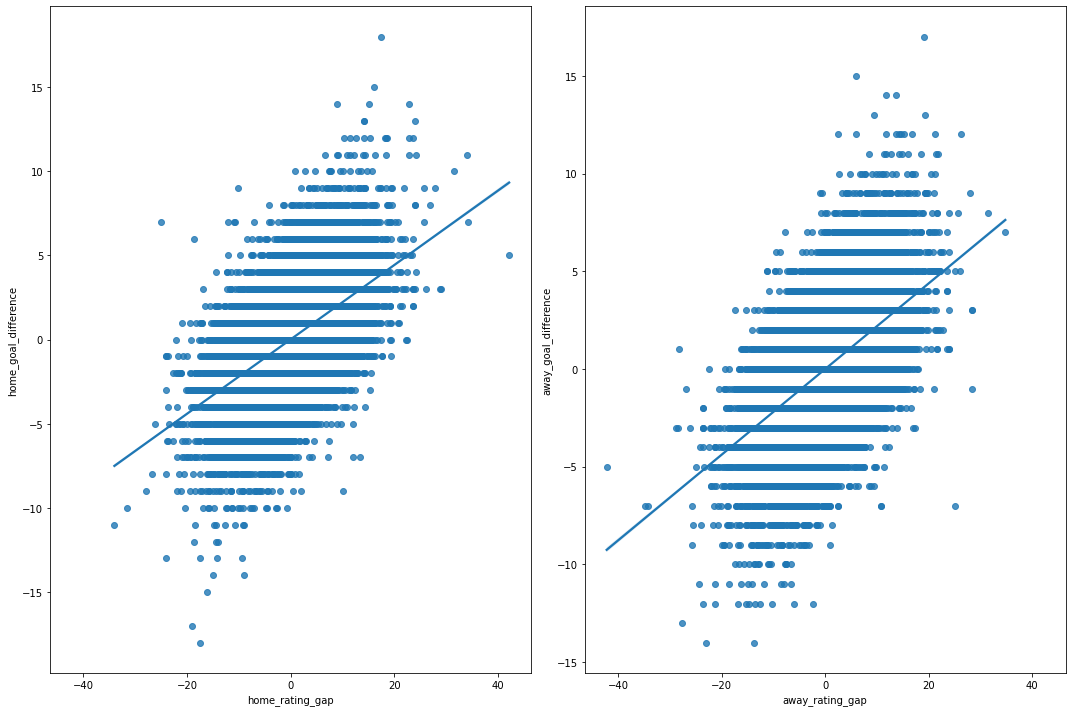

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(15,10))
sns.regplot(x=data['home_rating_gap'], y=data['home_goal_difference'], ax=ax1)
sns.regplot(x=data['away_rating_gap'], y=data['away_goal_difference'], ax=ax2)
plt.tight_layout()

#### Goals by Rating Bucket

When considering teams by rating, I believed it would be likely that there would be similarities of total goals scored between teams of similar rankings - Evidently, our assumption was correct here as well. As the rating of each of these buckets increases, the tails become much longer insinuating that there is a higher likelihood of more goals being scored by those teams. This was also proved in the previous regression plots, but this is another useful visualization.

In [15]:
bin1 = history_train.loc[(history_train.home_team_history_rating > 2) & (history_train.home_team_history_rating < 3)].home_team_history_goal
bin2 = history_train.loc[(history_train.home_team_history_rating > 4) & (history_train.home_team_history_rating < 5)].home_team_history_goal
bin3 = history_train.loc[(history_train.home_team_history_rating > 9) & (history_train.home_team_history_rating < 10)].home_team_history_goal
bin4 = history_train.loc[(history_train.home_team_history_rating > 15) & (history_train.home_team_history_rating < 20)].home_team_history_goal

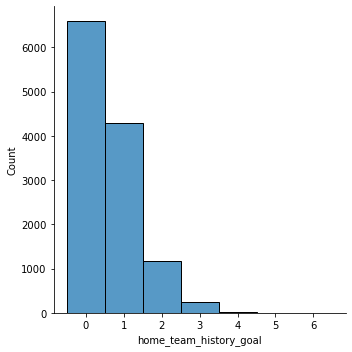

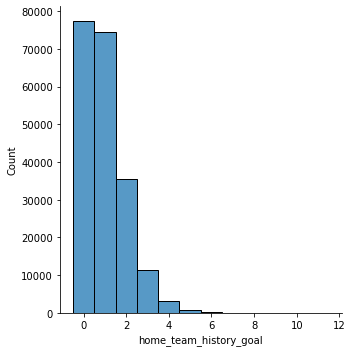

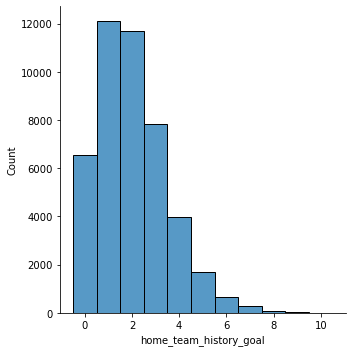

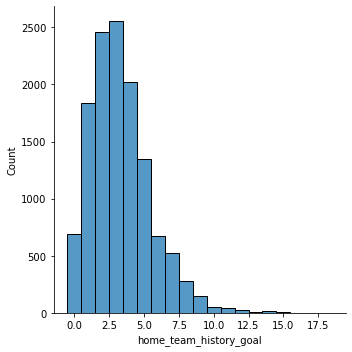

In [16]:
sns.displot(bin1, discrete=True)
sns.displot(bin2, discrete=True)
sns.displot(bin3, discrete=True)
sns.displot(bin4, discrete=True)

#### Exploring Correlations in Historical Data

Using a heatmap, we can see that the strongest correlation is between the rating gaps & goal differentials as mentioned previously. This relationship between goal related features & team ratings remains consistent throughout the historical data as well. Additionally, there is also a correlation between a teams current rating & their historical rating, which is pretty intuitive & should not help us too much in our understanding of the data. 

<AxesSubplot:>

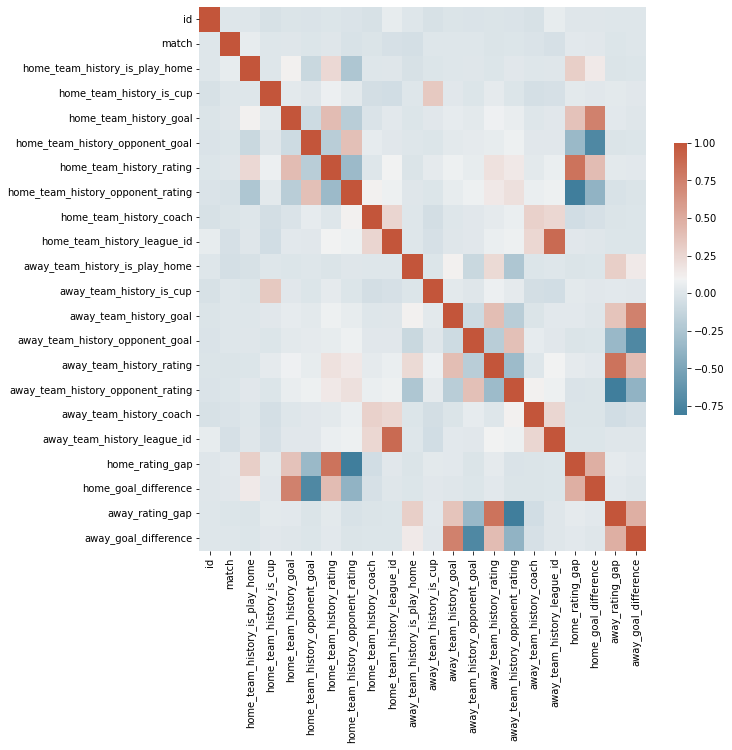

In [17]:
plt.figure(figsize=(10,10))

corr = history_train.corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, cbar_kws={"shrink": .5})

#### Exploring Goals Scored

Aside from some random noise present in this slice of the dataset, there is really no material difference between goals scored throughout the duration of a team's history - This was somewhat expected, as no other variable was introduced. Instead, I believe that when considering time between games, possibly meaning that players would be tired from short stints of rest, there would be some correlation with goals scored. In order to do this, we must engineer some features which I will do below.

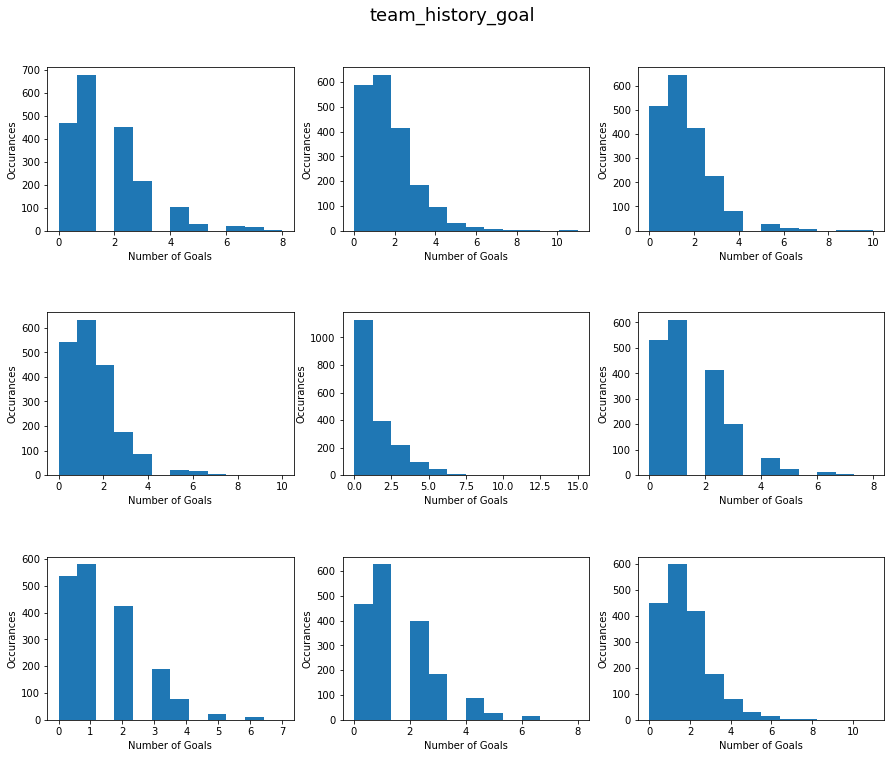

In [18]:
plot_all_historical_features(data[:2000], feature_name='team_history_goal', hist=True)

#### Investigate Wins & Win Streaks

In this case, we explore the wins data based on their respective Octosport team ratings. For some insight into our intuition behind 'expected' & 'unexpected', anytime a given team's rating is greater than their opponent they are considered to be the winner of the match. For this part of the exploration, our goal is to determine if the notion of a "home field advantage" is present within our data.

Considering this pie chart the *expected* wins comprise most of the pie - Surprisingly the *unexpected home wins* are the largest piece of the aggregated data, though by a small margin, thus showing the presence of the dreaded "home field advantage" commonly awknowledged in sports.

**KEY**:
* EHW: Expected Home Wins
* EAW: Expected Away Wins
* UHW: Unexpected Home Wins
* UAW: Unexpected Away Wins

([<matplotlib.patches.Wedge at 0x7fd1ea4705b0>,
 [Text(0.6868123625133976, 0.8592373238510799, 'EHW'),
  Text(-0.9879353202284178, 0.4837187230665916, 'EAW'),
  Text(-0.2354424745776357, -1.0745077203839717, 'UHW'),
  Text(1.0883832424476498, -0.5053928348909793, 'UAW')],
 [Text(0.37462492500730776, 0.46867490391877076, '28.5%'),
  Text(-0.5388738110336824, 0.26384657621814084, '28.4%'),
  Text(-0.12842316795143763, -0.5860951202094391, '29.2%'),
  Text(0.634890224761129, -0.2948124870197379, '13.8%')])

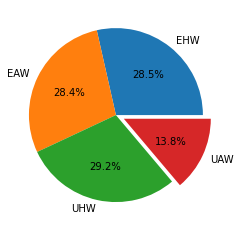

In [19]:
expected_home_wins, expected_away_wins, unexpected_home_wins, unexpected_away_wins = get_wins_data()
sizes = [expected_home_wins.size, expected_away_wins.size, unexpected_home_wins.size, unexpected_away_wins.size]
labels = ['EHW', 'EAW', 'UHW', 'UAW']
explode = (0, 0, 0, 0.1)

plt.pie(x=sizes, labels=labels, explode=explode, autopct='%1.1f%%')

#### Feature Engineering: Adding the Win/Loss Streak Feature

As mentioned in the function documentation @shariful07 had a great implementation of code that allows us to view streak data of teams. Interesting enough, this data follows somewhat of a normal distribution. Having this win streak data is incredibly important to our model, the term *hot hand* (ignoring the hot hand falacy theory...) is another popular theme in sports. Essentially, this means if a team is winning many games in a row then they are likely to continue winning in the future. Now this is true to a degree, but yes there is a limit to everything. Ensuring that we weigh win streaks properly in addition to our insights around rating gaps & goal differentials, will be crucial to building a solid model. 

In [20]:
data = add_streak(data)

#### Feature Engineering: Match Date Differential

Though we have already established that the goal differential is likely going to be our most impactful added feature, the difference between match dates may also provide insight into how a team is preforming. Essentially, the logic behind this is that teams could possibly get *rusty* should they have not played for a significant amount of time, or possibly tired should they be playing matches nearly every day. 

In [21]:
data = add_date_diff(data)

#### Feature Engineering: Inter-League Matches

The addition of this feature is driven by the idea that teams are likely to employ much different strategies in *must win* games, where as during exhbiition games it is likely that they will not even play their best players or let other rival teams scout their best schemas. This feature essentially OneHotEncodes the data into a single column, being 1 for an inter-league match (more representative of true performance) or 0 for an exhibition game. 

In [22]:
data = add_is_league_game(data)

#### Feature Engineering: ELO Score

Elo Score Explained: https://medium.com/purple-theory/what-is-elo-rating-c4eb7a9061e0

Essentially, this is another rating score that has been used in the past to rank chess players, and also in Mark Zuckerberg's FaceMash project in the movie *The Social Network*. Though I have not worked with this score in the past, it seems as if this may provide some of the best insights into a team's performance weighted over time.

In [23]:
data = add_elo_score(data)

#### Win Streak Histograms

As noted above, this data follows a gaussian distribution, which does make sense after putting some thought behind it - For example, it is much more likely that a team is average, thus flipping between wins/losses regularly, than it is a team is exceptional (or horrendously bad) and consistently winning/losing games. While there could possibly be some exceptions, the bulk of these average teams falls into the dense middle region of the distribution. 

<AxesSubplot:title={'center':'Away Team Win Streak'}, xlabel='Win Streak Total', ylabel='Occurances'>

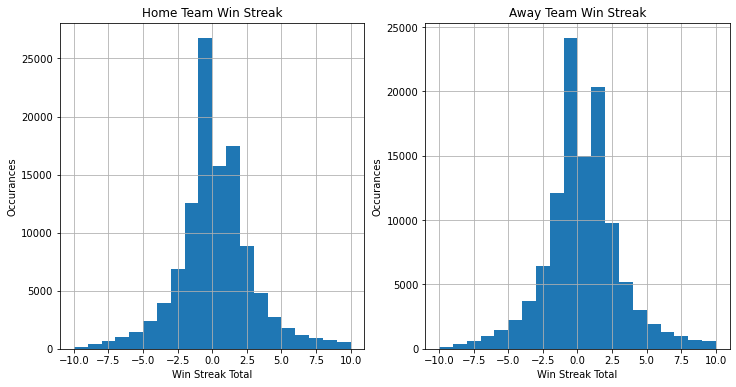

In [24]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.title('Home Team Win Streak')
plt.xlabel('Win Streak Total')
plt.ylabel('Occurances')
data['home_streak'].hist(bins=20)

plt.subplot(1, 2, 2)
plt.title('Away Team Win Streak')
plt.xlabel('Win Streak Total')
plt.ylabel('Occurances')
data['away_streak'].hist(bins=20)

#### Exploring Streaks & Goal Differential

To further analyze the quality of the teams that are currently on winning (or losing) streaks, we plot the goal differential data against the win streak values. While the winning streak data does not represent anything meaningful enough to generalize to, the teams currently on losing streaks seem to have larger losses (based on goal differential) which is certainly a useful piece of information. From playing sports during my life, this relationship is somewhat logical to me. Winning is never easy, yet losses can get extremely out of hand should there be disfunction within the team and that is likely what we are seeing here. 

<AxesSubplot:xlabel='away_streak', ylabel='away_goal_difference'>

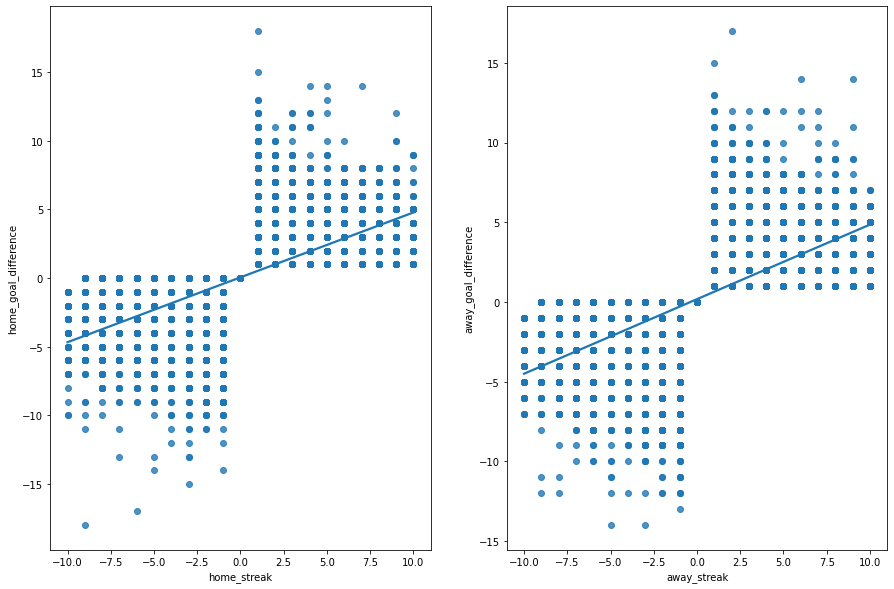

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(15,10));
sns.regplot(x=data['home_streak'], y=data['home_goal_difference'], ax=ax1)
sns.regplot(x=data['away_streak'], y=data['away_goal_difference'], ax=ax2)

#### League Exploration

As mentioned previously, the type and gravity (how important a match is) will likely impact the outcome of the match in *some* way. For many non-soccer fans, this may seem pointless, yet teams will employ much different strategies for games that play a factor into their championship title fight, as opposed to an exhibition (defined as "Club Friendlies" in the data) match. In fact, often times the team's best players will not even play in these exhibition games as they do not want to risk injury or energy for the more important matches. 

For some context, the most notable leagues, with star players such as Leo Messi & Cristiano Ronaldo, are the Premier League (EPL), Ligue 1, Serie A, and La Liga - There are a few more I could mention, but these really contain the best teams from recent years. Knowing this, we can see that the majority of our data does come from matches within these leagues (along with friendiles playing a significant role as well). 

In [26]:
data['league_name'].value_counts()

Premier League         5565
Club Friendlies        3724
Primera Division       2369
Super League           1530
3. Liga                1327
                       ... 
Play-offs 2/3             1
Trofeo Joan Gamper        1
4. Liga Division F        1
Copa Paraguay             1
National 3: Group L       1
Name: league_name, Length: 727, dtype: int64

<AxesSubplot:title={'center':'League Occurances: 640:650'}>

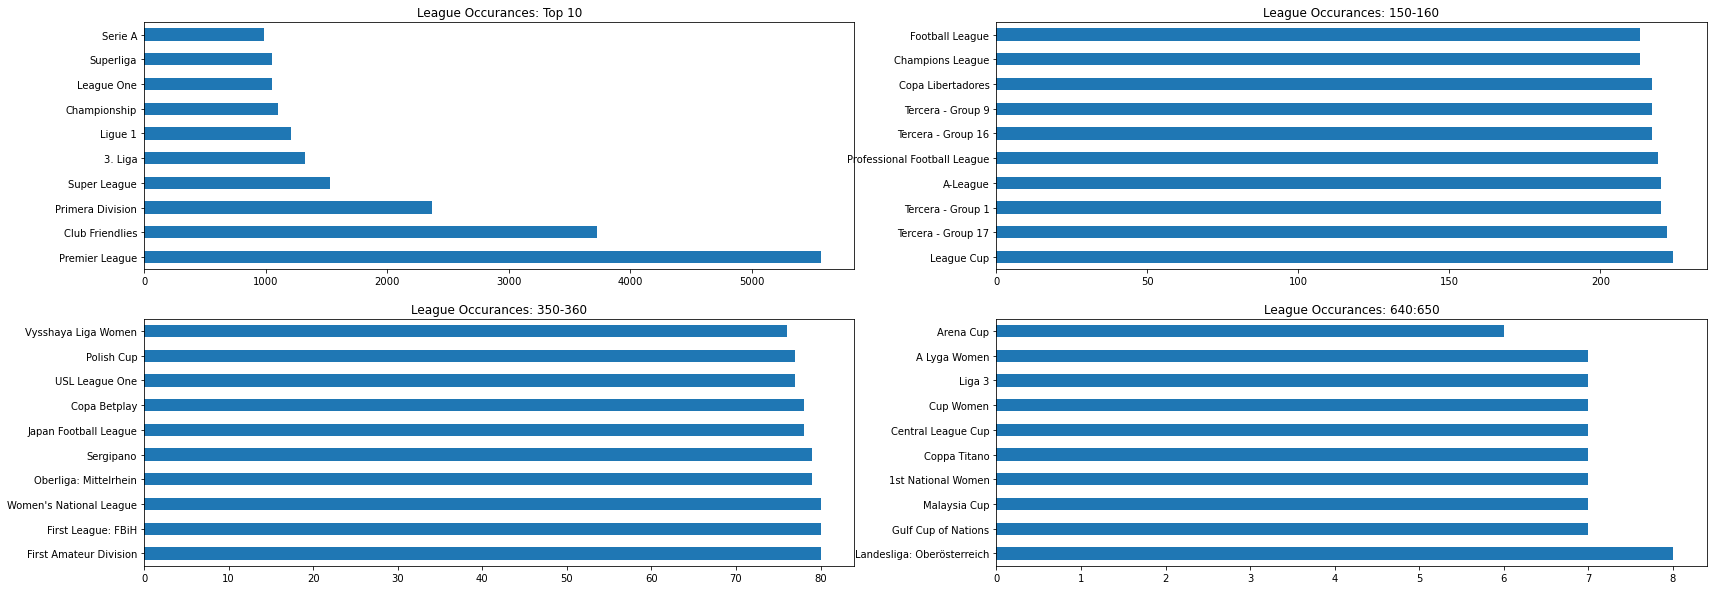

In [27]:
plt.figure(figsize=(28, 10))

plt.subplot(2, 2, 1)
plt.title('League Occurances: Top 10')
data['league_name'].value_counts()[:10].plot.barh()

plt.subplot(2, 2, 2)
plt.title('League Occurances: 150-160')
data['league_name'].value_counts()[150:160].plot.barh()

plt.subplot(2, 2, 3)
plt.title('League Occurances: 350-360')
data['league_name'].value_counts()[350:360].plot.barh()

plt.subplot(2, 2, 4)
plt.title('League Occurances: 640:650')
data['league_name'].value_counts()[640:650].plot.barh()

#### Comparative League Exploration

Now, let's explore by individual league and see if there are any differences in performances by teams within each...

In [28]:
data.loc[lambda data: data['league_name'] == 'Serie A']['home_goal_difference'].mean()

-0.03147208121827411

In [29]:
data.columns

Index(['id', 'target', 'home_team_name', 'away_team_name', 'match_date',
       'league_name', 'league_id', 'is_cup', 'home_team_coach_id',
       'away_team_coach_id',
       ...
       'home_away_team_history_elo_score_7', 'home_team_history_elo_score_8',
       'away_team_history_elo_score_8', 'home_away_team_history_elo_score_8',
       'home_team_history_elo_score_9', 'away_team_history_elo_score_9',
       'home_away_team_history_elo_score_9', 'home_team_history_elo_score_10',
       'away_team_history_elo_score_10',
       'home_away_team_history_elo_score_10'],
      dtype='object', length=266)

In [30]:
main_leagues = ['Serie A', 'Ligue 1', 'Premier League', 'La Liga']
special_leagues = ['Super League', 'Champions League']
# other_leagues = ...

main_leagues_home_streak = get_league_info(data, main_leagues, 'home_streak')
special_leagues_home_streak = get_league_info(data, special_leagues, 'home_streak')
main_leagues_away_streak = get_league_info(data, main_leagues, 'away_streak')
special_leagues_away_streak = get_league_info(data, special_leagues, 'away_streak')


main_leagues_home_goal_diff = get_league_info(data, main_leagues, 'home_goal_difference')
special_leagues_home_goal_diff = get_league_info(data, special_leagues, 'home_goal_difference')
main_leagues_away_goal_diff = get_league_info(data, main_leagues, 'away_goal_difference')
special_leagues_away_goal_diff = get_league_info(data, special_leagues, 'away_goal_difference')

main_leagues_home_rating_gap = get_league_info(data, main_leagues, 'home_rating_gap')
special_leagues_home_rating_gap = get_league_info(data, special_leagues, 'home_rating_gap')
main_leagues_away_rating_gap = get_league_info(data, main_leagues, 'away_rating_gap')
special_leagues_away_rating_gap = get_league_info(data, special_leagues, 'away_rating_gap')

### Main League vs. Special League: Win Streaks

#### Home Team Win Streaks

In general, the standard error of win streaks for teams in both main leagues & special leagues stays relatively consistent, though team in the Champions League typically have a much stronger mean value than that of any other league. For anyone that knows soccer, this actually makes a lot of sense. As a bit of context, the Champions League is comprised of all the best club teams in the world, including those of the main leagues shown on the right. So, should these pre-defined teams be playing someone else of a lower classifcation, it would make sense that they would win more often.

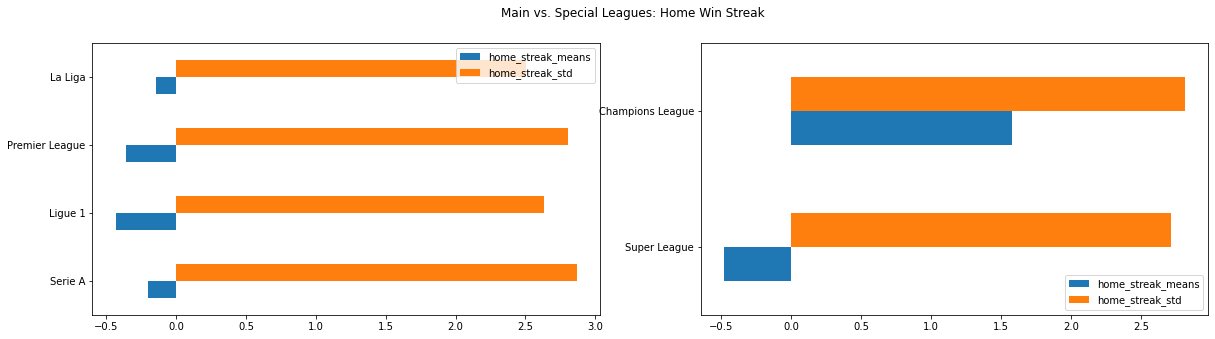

In [31]:
plot_comparative_barh(main_leagues_home_streak, special_leagues_home_streak, 'Home Win Streak')

#### Away Team Win Streaks
To confirm the thought in the previous graph, this chart of the Away teams standard deviation & means clearly shows the same trend.

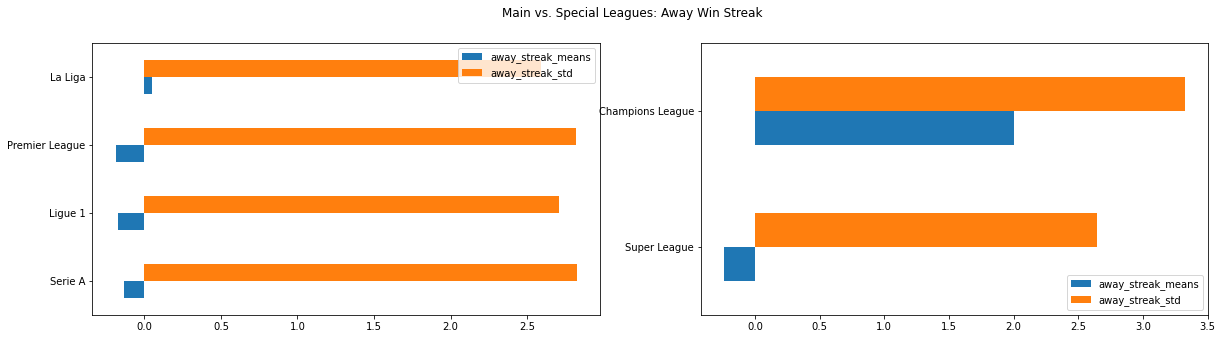

In [32]:
plot_comparative_barh(main_leagues_away_streak, special_leagues_away_streak, 'Away Win Streak')

### Main League vs. Special League: Goal Differential

#### Home Team Goal Differential

Again, while there is no distinct pattern in any of the main leagues, the Champions League is still showing a significant difference in their goal differential statistic. This would also coeincide with the earlier graphs on win streak (as you need to score more than the other team to win), yet it gives us some more color into how these teams are actually preforming on a game-by-game basis.

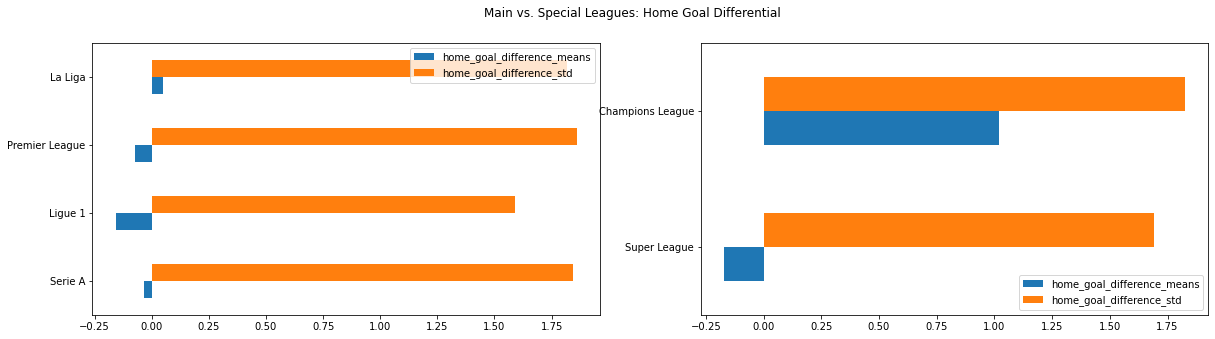

In [33]:
plot_comparative_barh(main_leagues_home_goal_diff, special_leagues_home_goal_diff, 'Home Goal Differential')

#### Away Team Goal Differential

Oddly enough, it seems the away teams in each of the main leagues has a positive goal differential, which would suggest they are much more competitive than expected in inter-league contents where home field advantage may play a signifcant role. Otherwise, the trend with the Champions League remains consistent here as well.

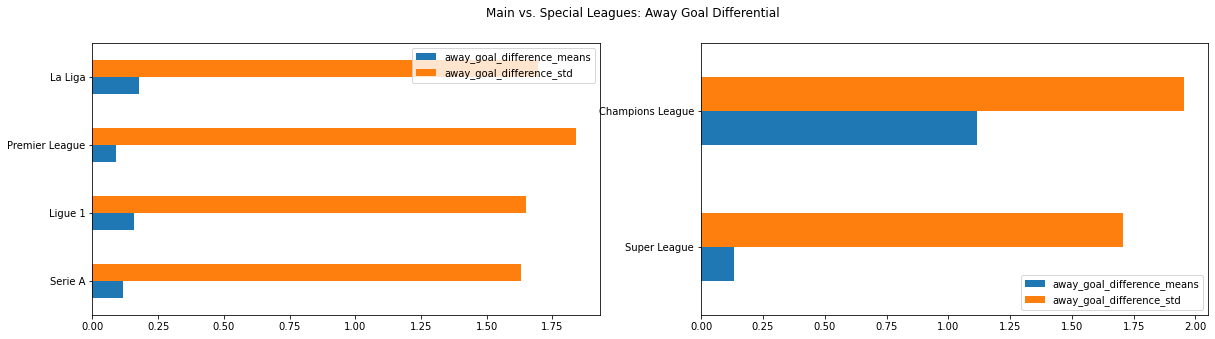

In [34]:
plot_comparative_barh(main_leagues_away_goal_diff, special_leagues_away_goal_diff, 'Away Goal Differential')

### Main League vs. Special League: Rating Differential

#### Home Team Rating Differential

Unsurprsingly, the Champions League & their mean rating differential is off the charts, while Ligue 1 lags behind massively likely due to only a few top teams being present in the league.

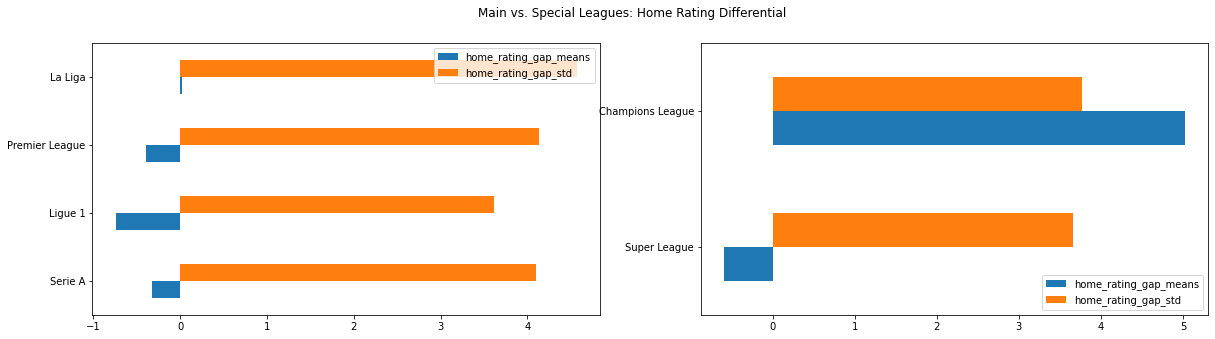

In [35]:
plot_comparative_barh(main_leagues_home_rating_gap, special_leagues_home_rating_gap, 'Home Rating Differential')

#### Away Team Rating Differential

Again, this trend of away teams preforming well in the main leagues is quite odd, here showing a significant rating differential across the board. Though this was surprising, our trend  with Champions League teams remaining the strongest holds true, and Super League teams begin to pull their weight a bit as well. 

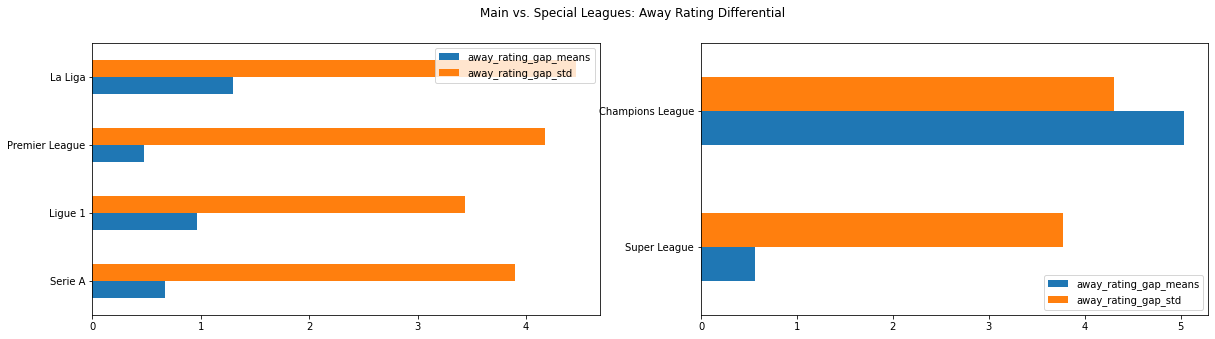

In [36]:
plot_comparative_barh(main_leagues_away_rating_gap, special_leagues_away_rating_gap, 'Away Rating Differential')

In [37]:
data.shape, X_train.shape

((110938, 266), (94297, 189))

## Prepare the Data

#### Add Engineered Features to Train & Test

In [38]:
def add_all_features(data):
    add_streak(data)
    add_date_diff(data)
    add_is_league_game(data)
    add_elo_score(data)
    return data

In [39]:
X_train = add_all_features(X_train)
X_test = add_all_features(X_test)

### Aggregate Features for Preprocessing

#### Prepare Data for Imputation

Well, there is a **ton** of missing data here, as mentioned early on in our discovery - Unfortunately, it is likely we are going to have to handle most of these NaN's manually, and not use an Imputer.

### Impute: Home & Away, and League Name

In [40]:
# to be dealt with via imputing, scaling, etc...
score_cols = [col for col in X_train.columns if 'score' in col]
rating_cols = [col for col in X_train.columns if 'rating' in col]
goal_cols = [col for col in X_train.columns if 'goal' in col]

# to be dropped...
id_cols = [col for col in X_train if 'id' in col]
name_cols = [col for col in X_train if 'name' in col]
date_cols = [col for col in X_train.columns if 'date' in col]
coach_cols = [col for col in X_train.columns if 'coach' in col]
league_cols = [col for col in X_train.columns if 'league' in col]
obj_cols = [col for col in X_train if X_train[col].dtype == 'object']

# tbd...
impute_cols = [col for col in X_train if X_train[col].isnull().sum() > 0]

In [41]:
drop_cols = [*name_cols, *obj_cols, *date_cols, *league_cols, *coach_cols, *id_cols]
num_cols = [*score_cols, *rating_cols, *goal_cols]

In [42]:
for x in X_train.columns:
    print(f'{x}: {X_train[x].isnull().sum()}')

id: 0
home_team_name: 1
away_team_name: 1
match_date: 0
league_name: 1
league_id: 0
is_cup: 1
home_team_coach_id: 18459
away_team_coach_id: 18536
home_team_history_match_date_1: 996
home_team_history_match_date_2: 2088
home_team_history_match_date_3: 3227
home_team_history_match_date_4: 4340
home_team_history_match_date_5: 5510
home_team_history_match_date_6: 6723
home_team_history_match_date_7: 7936
home_team_history_match_date_8: 9160
home_team_history_match_date_9: 10348
home_team_history_match_date_10: 11562
home_team_history_is_play_home_1: 996
home_team_history_is_play_home_2: 2088
home_team_history_is_play_home_3: 3227
home_team_history_is_play_home_4: 4340
home_team_history_is_play_home_5: 5510
home_team_history_is_play_home_6: 6723
home_team_history_is_play_home_7: 7936
home_team_history_is_play_home_8: 9160
home_team_history_is_play_home_9: 10348
home_team_history_is_play_home_10: 11562
home_team_history_is_cup_1: 1046
home_team_history_is_cup_2: 2184
home_team_history_is_cup

### Pipeline

In [43]:
test = X_train.copy()

pipeline = Pipeline(steps=[

    ('num_trans', ColumnTransformer(transformers=[
        ('drop', 'drop', drop_cols),
        ('impute', KNNImputer(n_neighbors=2), num_cols),
        ('log', FunctionTransformer(np.log1p), num_cols),
        ('scale', MinMaxScaler(), num_cols),
    ], remainder='drop')),
])

In [44]:
X_train = pipeline.fit_transform(X_train)
X_train = np.where(np.isnan(X_train), np.nanmean(X_train, axis=0), X_train)
X_test = pipeline.fit_transform(X_test)
X_test = np.where(np.isnan(X_test), np.nanmean(X_test, axis=0), X_test)

KeyboardInterrupt: 

In [ ]:
X_train_tf = tf.convert_to_tensor(X_train)
y_train_tf = tf.convert_to_tensor(y_train_ohe)

## Short List Promising Models

### Simple RNN

In [ ]:
rnn_model = keras.models.Sequential([
    # keras.layers.Flatten(input_shape=test_tensor[0].shape, name='input'),
    keras.layers.SimpleRNN(100, return_sequences=True, name='hidden_1', input_shape=(None, 1)),
    keras.layers.SimpleRNN(20, return_sequences=True, name='hidden_2'),
    keras.layers.SimpleRNN(3)
])

# compile the model
rnn_model.compile(optimizer=keras.optimizers.Adam(clipvalue=0.5), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# fit the model
rnn_model.fit(X_train_tf, y_train_tf, epochs=10)

In [ ]:
rnn_model2 = keras.models.Sequential([
    # keras.layers.Flatten(input_shape=test_tensor[0].shape, name='input'),
    keras.layers.SimpleRNN(100, return_sequences=True, name='hidden_1', input_shape=(None, 1)),
    keras.layers.SimpleRNN(80, return_sequences=True, name='hidden_2'),
    keras.layers.SimpleRNN(60, return_sequences=True, name='hidden_3'),
    keras.layers.SimpleRNN(40, return_sequences=True, name='hidden_4'),
    keras.layers.SimpleRNN(40, return_sequences=True, name='hidden_5'),
    keras.layers.SimpleRNN(3, name='output')
])

# compile the model
rnn_model.compile(optimizer=keras.optimizers.Adam(clipvalue=0.5), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# fit the model
rnn_model.fit(X_train_tf, y_train_tf, epochs=10)

### LSTM

In [ ]:
lstm_model = keras.models.Sequential([
    # keras.layers.Flatten(input_shape=test_tensor[0].shape, name='input'),
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.LSTM(3)
])

# compile the model
lstm_model.compile(optimizer=keras.optimizers.Adam(clipvalue=0.5), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

# # fit the model
lstm_model.fit(X_train_tf, y_train_tf, epochs=10)

## Classification Models

#### Reshape the Target Values

In [ ]:
y_train_reshaped = y_train_ohe.reshape(-1)

### Random Forest

In [ ]:
rf = RandomForestClassifier(max_depth=10, max_features=10).fit(X_train, y_train_reshaped)
accuracy_score(y_train_reshaped, rf.predict(X_train)), cross_val_score(rf, X_train, y_train_reshaped, scoring='accuracy',cv=3).mean(),log_loss(y_train_reshaped, rf.predict(X_train))

In [ ]:
param_grid = [
    {
        'max_depth': [8, 9, 10, 11, 12],
        'min_samples_leaf': [20, 30, 40, ],
        'n_estimators': [3, 4, 5, 7, 10],

    }
]

vote_search = GridSearchCV(
    rf, param_grid=param_grid,
    cv=5, scoring='accuracy'
)

vote_search.fit(X_train, y_train)
vote_search.best_params_, vote_search.best_score_

### Logistic Regression

In [ ]:
y_train_reshaped = y_train.reshape(-1)

In [ ]:
og_reg = LogisticRegression(max_iter=100).fit(X_train, y_train_reshaped)
accuracy_score(y_train_reshaped, log_reg.predict(X_train)), cross_val_score(log_reg, X_train, y_train_reshaped, scoring='accuracy',cv=3).mean(), log_loss(y_train_reshaped, log_reg.predict(X_train))

### Voting

In [ ]:
oting_clf = VotingClassifier(
    [('log-reg', log_reg),('rf', rf)],
    voting='soft'
)
voting_clf.fit(X_train, y_train_reshaped)
accuracy_score(y_train_reshaped, voting_clf.predict(X_train)), cross_val_score(voting_clf, X_train, y_train_reshaped, scoring='accuracy',cv=3).mean(), log_loss(y_train_reshaped, voting_clf.predict(X_train))

In [ ]:
voting_clf.get_params().keys()

In [ ]:
param_grid = {
    'log-reg__max_iter': [2, 3, 4, 5, 10],
    'log-reg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'rf__min_samples_leaf': [20, 30, 40],
    'rf__max_depth': [8, 9, 10, 11, 12],
    'rf__n_estimators': [3, 4, 5, 7, 10],
}


vote_search = GridSearchCV(
    voting_clf, param_grid=param_grid,
    cv=5, scoring='accuracy'
)

vote_search.fit(X_train, y_train_reshaped)
vote_search.best_params_, vote_search.best_score_, log_loss(y_train_reshaped, vote_search.predict())

In [ ]:
log_loss(y_train_reshaped, vote_search.predict(X_train))

### Deciding on the RNN Model

As it was the suggested solution, the Simple RNN model certainly showed the most promise on a log-loss adjusted basis. This is likely due to the nature of a recurrent neural network, and it's ability to understand complex & sequential data. On the other hand, the simple classification models were not able to understand the higher dimensions of historical data and could thus could not generalize the data it fit from these features to new instances. Though our model is far from complete, as we have not 'beat the book' yet, this RNN provides us a solid foundation that we can refer back to and use once we are ready to optimize our model. 

Though we do not expect to make an incedible amount of changes to our model (though there are certianly ways it must be optimzied in, of course), some of the optimizations we expect can be described as:
* Higher quality data (ie. less missing)
* More frequent match data
* Information involving lineups for individual matches (accounts for injuries)
* Weather data that could be affecting performance
* Sentiment & market analysis for the odds for individual games

In [ ]:
rnn_model.evaluate(X_train, y_test)

## Save the Model

With TensorFlow & Keras models, there is no need to use a Pickle file, rather they can be saved & loaded through TF directly...

In [ ]:
rnn_model.save('model.keras')

In [ ]:
with open('voting_model.pkl', 'wb') as f:
    pickle.dump(vote_search, f, pickle.HIGHEST_PROTOCOL) 